In [ ]:
!pip -q install transformers torch accelerate

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"   # also try: "roberta-base"
tok = AutoTokenizer.from_pretrained(model_name)
mdl = AutoModel.from_pretrained(model_name, output_attentions=True)
mdl.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
sent_sports  = "The New England Patriots will win Super Bowl 2026."
sent_weather = "New England winters can be really cold and long."

sents = [sent_sports, sent_weather]
labels = ["sports", "weather"]

def find_subsequence(tokens, subseq):
    """Return start index of subseq in tokens, or -1."""
    for i in range(len(tokens) - len(subseq) + 1):
        if tokens[i:i+len(subseq)] == subseq:
            return i
    return -1

def pretty_tokens(tokenizer, input_ids):
    return tokenizer.convert_ids_to_tokens(input_ids[0])

In [ ]:
def run_and_extract(sentence, phrase_tokens_options):
    """
    phrase_tokens_options: list of token sequences to try, e.g.
      [["new", "england"], ["ĠNew", "ĠEngland"], ...]
    """
    inp = tok(sentence, return_tensors="pt")
    with torch.no_grad():
        out = mdl(**inp)

    tokens = pretty_tokens(tok, inp["input_ids"])
    H = out.last_hidden_state[0]  # (seq, hidden)

    # Find phrase span in token list
    start = -1
    phrase = None
    for opt in phrase_tokens_options:
        start = find_subsequence(tokens, opt)
        if start != -1:
            phrase = opt
            break

    if start == -1:
        raise ValueError(f"Could not find phrase tokens in: {tokens}")

    span_idx = list(range(start, start + len(phrase)))
    span_emb = H[span_idx].mean(dim=0)  # mean pooling over phrase tokens

    return {
        "tokens": tokens,
        "span_idx": span_idx,
        "span_emb": span_emb.cpu().numpy(),
        "attentions": out.attentions,  # tuple[n_layers] of (batch, heads, seq, seq)
        "input_ids": inp["input_ids"]
    }

# Tokenization variants to try (BERT uses WordPiece; RoBERTa uses Ġ marker)
phrase_opts = [
    ["new", "england"],          # bert-base-uncased
    ["New", "England"],          # if casing differs
    ["ĠNew", "ĠEngland"],        # roberta-base style
    ["Ġnew", "Ġengland"],
]

runs = [run_and_extract(s, phrase_opts) for s in sents]

Cosine similarity between contextual 'New England' embeddings:
  sports vs weather: 0.5362


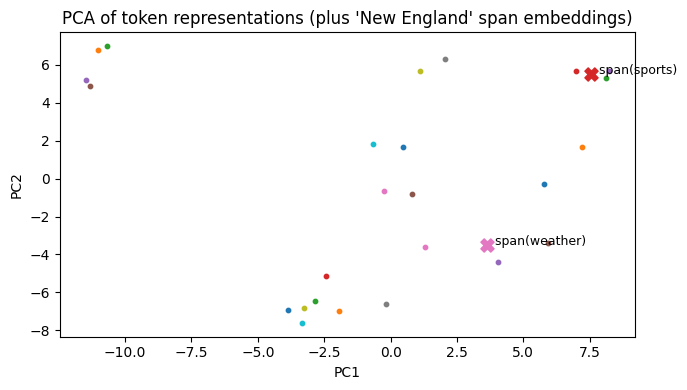

In [ ]:
def cosine(a, b, eps=1e-12):
    a = np.asarray(a); b = np.asarray(b)
    return float(a @ b / (np.linalg.norm(a)*np.linalg.norm(b) + eps))

e0, e1 = runs[0]["span_emb"], runs[1]["span_emb"]
print("Cosine similarity between contextual 'New England' embeddings:")
print("  sports vs weather:", round(cosine(e0, e1), 4))

# PCA to 2D for a visual: include both span embeddings + all token embeddings of each sentence
# (quick PCA without sklearn)
def pca2(X):
    X = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    return X @ Vt[:2].T

# build a point cloud: all tokens from both sentences + both span points
all_points = []
point_meta = []

for k, r in enumerate(runs):
    # get hidden states again for all tokens (already in model output but we stored only span)
    inp = r["input_ids"]
    with torch.no_grad():
        out = mdl(input_ids=inp, attention_mask=torch.ones_like(inp))
    H = out.last_hidden_state[0].cpu().numpy()
    for i in range(H.shape[0]):
        all_points.append(H[i])
        point_meta.append((labels[k], "token", i))
    all_points.append(r["span_emb"])
    point_meta.append((labels[k], "span", None))

X2 = pca2(np.vstack(all_points))

plt.figure(figsize=(7,4))
for (lab, typ, idx), (x,y) in zip(point_meta, X2):
    if typ == "span":
        plt.scatter(x, y, s=90, marker="X")
        plt.text(x, y, f"  span({lab})", fontsize=9)
    else:
        plt.scatter(x, y, s=10)
plt.title("PCA of token representations (plus 'New England' span embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [ ]:
def topk_attention_targets(run, token_pos, layer=-1, head=0, k=8):
    attn = run["attentions"][layer][0, head, token_pos].cpu().numpy()  # (seq,)
    tokens = run["tokens"]
    top = np.argsort(-attn)[:k]
    return [(tokens[j], float(attn[j])) for j in top]

layer = -1
head = 0
k = 10

for r, lab in zip(runs, labels):
    toks = r["tokens"]
    span_idx = r["span_idx"]
    print("\n=== Sentence:", lab, "===")
    print("Tokens:", toks)
    for pos in span_idx:
        print(f"\nSource token pos {pos}: {toks[pos]}")
        for t, w in topk_attention_targets(r, pos, layer=layer, head=head, k=k):
            print(f"  -> {t:>12s}  {w:.4f}")


=== Sentence: sports ===
Tokens: ['[CLS]', 'the', 'new', 'england', 'patriots', 'will', 'win', 'super', 'bowl', '202', '##6', '.', '[SEP]']

Source token pos 2: new
  ->            .  0.5243
  ->        [SEP]  0.4631
  ->         bowl  0.0028
  ->        [CLS]  0.0025
  ->          202  0.0013
  ->          the  0.0012
  ->         will  0.0010
  ->        super  0.0010
  ->      england  0.0008
  ->          new  0.0006

Source token pos 3: england
  ->            .  0.5166
  ->        [SEP]  0.4598
  ->        [CLS]  0.0043
  ->         bowl  0.0039
  ->      england  0.0030
  ->          202  0.0027
  ->          the  0.0023
  ->        super  0.0021
  ->          new  0.0017
  ->         will  0.0015

=== Sentence: weather ===
Tokens: ['[CLS]', 'new', 'england', 'winters', 'can', 'be', 'really', 'cold', 'and', 'long', '.', '[SEP]']

Source token pos 1: new
  ->            .  0.5429
  ->        [SEP]  0.4144
  ->        [CLS]  0.0113
  ->      winters  0.0110
  ->      england  0.0

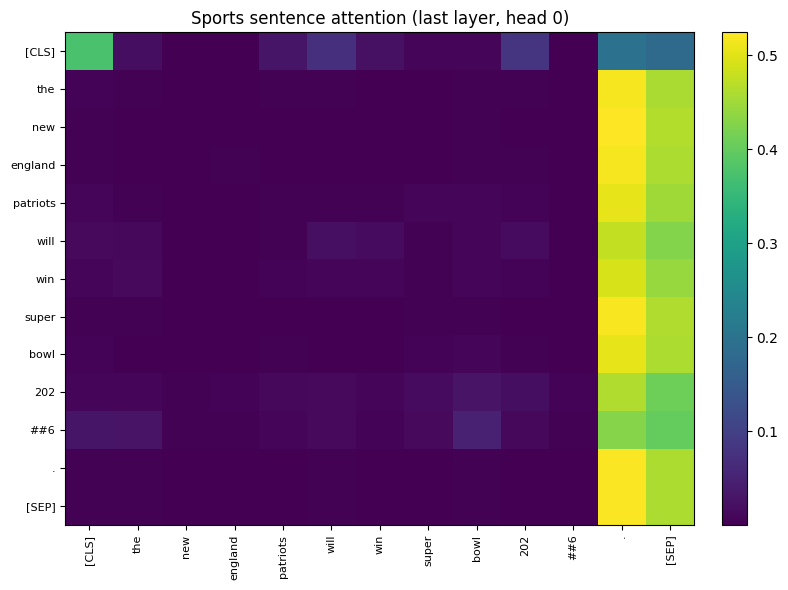

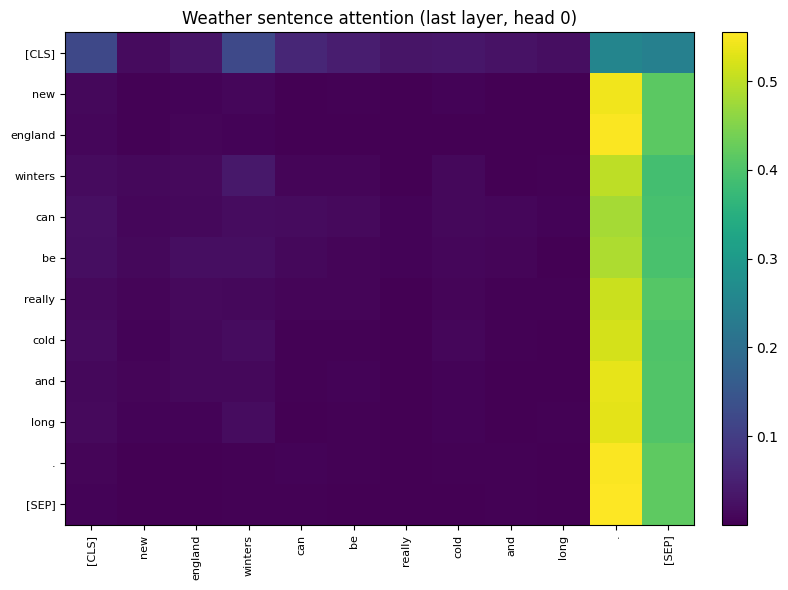

In [ ]:
def plot_attention_heatmap(run, layer=-1, head=0, max_tokens=40, title=""):
    A = run["attentions"][layer][0, head].cpu().numpy()  # (seq, seq)
    toks = run["tokens"]
    L = min(len(toks), max_tokens)
    plt.figure(figsize=(8,6))
    im = plt.imshow(A[:L,:L], aspect="auto", interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(L), toks[:L], rotation=90, fontsize=8)
    plt.yticks(range(L), toks[:L], fontsize=8)
    plt.title(title or f"Attention heatmap (layer {layer}, head {head})")
    plt.tight_layout()
    plt.show()

plot_attention_heatmap(runs[0], layer=-1, head=0, title="Sports sentence attention (last layer, head 0)")
plot_attention_heatmap(runs[1], layer=-1, head=0, title="Weather sentence attention (last layer, head 0)")

In [ ]:
!pip -q install bertviz transformers torch

import torch
from transformers import AutoTokenizer, AutoModel
from bertviz import head_view

model_name = "bert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)
mdl = AutoModel.from_pretrained(model_name, output_attentions=True)
mdl.eval()

text = "The New England Patriots will win Super Bowl 2026."
inputs = tok(text, return_tensors="pt")
with torch.no_grad():
    out = mdl(**inputs)

tokens = tok.convert_ids_to_tokens(inputs["input_ids"][0])
attn = out.attentions  # tuple of (batch, heads, seq, seq)

head_view(attn, tokens)   # interactive in notebook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 134.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.3 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

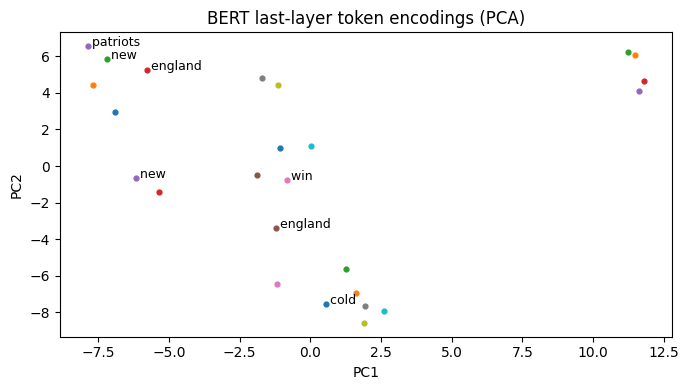

In [ ]:
!pip -q install transformers torch

import torch, numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)
mdl = AutoModel.from_pretrained(model_name, output_hidden_states=True)
mdl.eval()

sents = [
    "The New England Patriots will win Super Bowl 2026.",
    "New England winters can be really cold and long."
]

def pca2(X):
    X = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    return X @ Vt[:2].T

layer = -1  # last layer
points = []
meta = []

for si, sent in enumerate(sents):
    inp = tok(sent, return_tensors="pt")
    with torch.no_grad():
        out = mdl(**inp)
    H = out.hidden_states[layer][0].cpu().numpy()  # (seq, hidden)
    toks = tok.convert_ids_to_tokens(inp["input_ids"][0])
    for i in range(len(toks)):
        points.append(H[i])
        meta.append((si, toks[i]))

X2 = pca2(np.vstack(points))

plt.figure(figsize=(7,4))
for (si, tk), (x,y) in zip(meta, X2):
    plt.scatter(x, y, s=12)
    if tk in ["new", "england", "patriots", "win", "winter", "cold"]:
        plt.text(x, y, f" {tk}", fontsize=9)
plt.title("BERT last-layer token encodings (PCA)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [ ]:
!pip -q install bertviz transformers torch

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from bertviz import head_view

model_name = "bert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)
mdl = AutoModel.from_pretrained(model_name, output_attentions=True)
mdl.eval()

sent_sports  = "The New England Patriots will win Super Bowl 2026."
sent_weather = "New England winters can be really cold and long."

def run(sentence):
    inputs = tok(sentence, return_tensors="pt")
    with torch.no_grad():
        out = mdl(**inputs)
    tokens = tok.convert_ids_to_tokens(inputs["input_ids"][0])
    return tokens, out.attentions

tokens1, attn1 = run(sent_sports)
tokens2, attn2 = run(sent_weather)

# Interactive visualization (matches the O'Reilly-style view)
head_view(attn1, tokens1)   # sports
head_view(attn2, tokens2)   # weather

# ---- Print a "soft Hom(A,-)" row for a chosen layer/head and source token
def show_soft_hom(tokens, attentions, source_token_str="england", layer=-1, head=0, topk=10):
    # attentions[layer]: (batch, heads, seq, seq)
    A = None
    for i, tk in enumerate(tokens):
        if tk == source_token_str:
            A = i; break
    if A is None:
        print(f"Token '{source_token_str}' not found. Available tokens: {tokens}")
        return

    alpha = attentions[layer][0, head, A].cpu().numpy()  # (seq,)
    top = np.argsort(-alpha)[:topk]
    print(f"\nSoft Hom({source_token_str}, -) as attention weights (layer {layer}, head {head}):")
    print("source index:", A)
    for j in top:
        print(f"  {tokens[j]:>12s}   α={alpha[j]:.4f}")

show_soft_hom(tokens1, attn1, source_token_str="england", layer=-1, head=0, topk=10)
show_soft_hom(tokens2, attn2, source_token_str="england", layer=-1, head=0, topk=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Soft Hom(england, -) as attention weights (layer -1, head 0):
source index: 3
             .   α=0.5166
         [SEP]   α=0.4598
         [CLS]   α=0.0043
          bowl   α=0.0039
       england   α=0.0030
           202   α=0.0027
           the   α=0.0023
         super   α=0.0021
           new   α=0.0017
          will   α=0.0015

Soft Hom(england, -) as attention weights (layer -1, head 0):
source index: 2
             .   α=0.5509
         [SEP]   α=0.4140
         [CLS]   α=0.0106
       england   α=0.0088
       winters   α=0.0067
           new   α=0.0026
          cold   α=0.0021
            be   α=0.0018
           can   α=0.0015
           and   α=0.0006
